通过正则化，例如权重衰减来避免过拟合

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

按照类似的形式来生成数据

我们选择标签是关于输入的线性函数。 标签同时被均值为0，标准差为0.01高斯噪声破坏。 为了使过拟合的效果更加明显，我们可以将问题的维数增加到200， 并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

初始化模型参数

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

定义L2范数惩罚

可以简单地表示为对所有项求平方后求和

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

训练程序

In [ ]:
def train(lambd):
    w, b = init_params()
    # net是一个匿名函数，接受输入x并通过调用linreg函数来进行线性回归预测；loss使用均方损失函数
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss

    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)  # 在原来损失函数的基础上再增加一个惩罚项，同时这个影响用lamdaJon控制
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)

        # 每5轮进行一次可视化
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

忽略正则化直接训练

w的L2范数是： 13.451358795166016


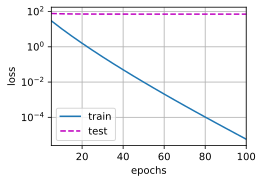

In [6]:
# lambda=0时，L2范数惩罚项为0

train(lambd=0)

利用正则化进行训练

此时，虽然训练误差增大，但是测试误差减小

w的L2范数是： 0.3465736508369446


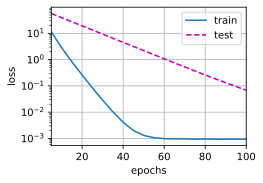

In [7]:
train(lambd=3)

简洁实现

wd是权重衰减(L2正则化)的强度系数

In [9]:
def train_concise(wd):
    # 直接使用torch的内置函数来实现L2范数惩罚项

    # 设定一个全连接层，等同于之前的线性回归模型
    net = nn.Sequential(nn.Linear(num_inputs, 1))

    # 初始化网络参数
    for param in net.parameters():
        param.data.normal_()  # 使用标准正态分布初始化每个参数

    # 定义损失函数
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003

    # 创建优化器，使用随机梯度下降，并设置不同参数组的优化选项
    # 创建了两个参数组，第一组包含全连接层的权重矩阵，第二组包含全连接层的偏置向量
    # 这样在更新时
    # 第一组：weight_grad = weight.grad + wd * weight
    # 第二组：bias_grad = bias.grad
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},  # 权重参数应用权重衰减
        {"params":net[0].bias}], lr=lr)  # 偏置参数不应用权重衰减

    # 创建动画器对象，用于可视化
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            # 这里没有显式添加L2正则化项，因为优化器的 weight_decay 参数会自动处理
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

类似地分别进行不考虑权重衰减和考虑权重衰减的计算

比较运行时间可以发现，通过这种方式实现的代码运行更快

w的L2范数： 13.178868293762207


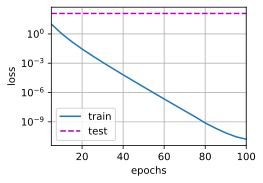

In [10]:
train_concise(0)

w的L2范数： 0.42615246772766113


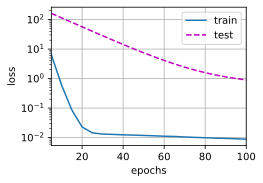

In [11]:
train_concise(3)